# HDB Resale Price Prediction

## Machine Learning Modelling

### Import Libraries

In [2]:
# General
import math
import random
random.seed(42)
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import randint

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn import tree

# Pre-Processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler      # Remove Mean and scale to Unit Variance
from sklearn.preprocessing import PowerTransformer    # Log Transformation
from sklearn.preprocessing import OneHotEncoder

# Feature Engineering
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# Evaluation Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# import lightgbm as ltb
import catboost as cb

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Warnings
import warnings
warnings.filterwarnings('ignore')

### Import Dataset

In [3]:
# Importing Data
data_hdb_cleaned = pd.read_csv('../dataset/hdb_last15_cleaned.csv')
data_hdb_cleaned.index += 1
data_hdb_cleaned

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,...,recreational_within_1km_average_rating,recreational_within_2km_count,recreational_within_2km_average_rating,education_within_1km_count,education_within_1km_average_rating,education_within_2km_count,education_within_2km_average_rating,postal_code,region,price_per_sqm
1,SEMBAWANG,5 ROOM,Premium Apartment,111.0,362000.0,2009-07-01,2001,01 TO 05,357A,91.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3261.261261
2,SEMBAWANG,5 ROOM,Premium Apartment,110.0,370000.0,2009-08-01,2001,06 TO 10,357A,91.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3363.636364
3,SEMBAWANG,5 ROOM,Premium Apartment,110.0,403000.0,2010-01-01,2001,16 TO 20,357A,90.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3663.636364
4,SEMBAWANG,4 ROOM,Premium Apartment,95.0,350000.0,2010-07-01,2001,01 TO 05,357A,90.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3684.210526
5,SEMBAWANG,4 ROOM,Premium Apartment,95.0,399000.0,2010-07-01,2001,10 TO 15,357A,90.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,4200.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316854,BUKIT MERAH,5 ROOM,Improved,114.0,921000.0,2022-10-01,1974,10 TO 15,87,50.750000,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,8078.947368
316855,BUKIT MERAH,5 ROOM,Improved,117.0,930000.0,2022-10-01,1974,01 TO 05,87,50.750000,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,7948.717949
316856,BUKIT MERAH,5 ROOM,Improved,117.0,978000.0,2022-12-01,1974,10 TO 15,87,50.666667,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,8358.974359
316857,BUKIT MERAH,5 ROOM,Improved,114.0,950000.0,2022-12-01,1974,21 TO 25,87,50.583333,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,8333.333333


In [4]:
# Understanding Data I
data_hdb_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316858 entries, 1 to 316858
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   town                                    316858 non-null  object 
 1   flat_type                               316858 non-null  object 
 2   flat_model                              316858 non-null  object 
 3   floor_area_sqm                          316858 non-null  float64
 4   resale_price                            316858 non-null  float64
 5   month                                   316858 non-null  object 
 6   lease_commence_date                     316858 non-null  int64  
 7   storey_range                            316858 non-null  object 
 8   block                                   316858 non-null  object 
 9   remaining_lease                         316858 non-null  float64
 10  address                                 3168

In [5]:
# Understanding Data II
data_hdb_cleaned.describe()

,floor_area_sqm,resale_price,lease_commence_date,remaining_lease,lat,long,nearest_distance_to_mrt,avg_long,avg_lat,healthcare_within_1km_count,...,recreational_within_1km_count,recreational_within_1km_average_rating,recreational_within_2km_count,recreational_within_2km_average_rating,education_within_1km_count,education_within_1km_average_rating,education_within_2km_count,education_within_2km_average_rating,postal_code,price_per_sqm
count,316858.000000,3.168580e+05,316858.00000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,...,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316410.000000,316858.000000
mean,97.479359,4.412566e+05,1991.72968,75.267866,1.365842,103.838676,0.624044,103.838680,1.365844,5.988376,...,3.837429,3.928042,11.887855,4.055404,4.855336,4.037460,14.403837,4.095730,551205.063677,4581.617630
std,24.742062,1.467689e+05,11.84791,11.684112,0.042881,0.072799,0.378055,0.072687,0.042815,5.242842,...,3.054143,0.688451,8.638953,0.134527,2.244488,0.574591,4.698377,0.183904,186035.992530,1181.663412
min,31.000000,1.270000e+05,1966.00000,43.000000,1.270380,103.644248,0.023000,103.688247,1.272255,0.000000,...,0.000000,0.000000,2.000000,3.577778,0.000000,0.000000,2.000000,2.786667,50004.000000,1445.920000
25%,74.000000,3.360000e+05,1984.00000,66.000000,1.336264,103.774173,0.337000,103.774336,1.336320,3.000000,...,2.000000,3.933333,8.000000,3.983333,3.000000,3.975000,12.000000,3.994737,470709.000000,3798.076923
50%,97.000000,4.150000e+05,1989.00000,75.000000,1.362565,103.844027,0.552000,103.844611,1.362350,5.000000,...,3.000000,4.050000,10.000000,4.075000,5.000000,4.133333,14.000000,4.130000,560323.000000,4368.932039
75%,113.000000,5.150000e+05,2000.00000,85.000000,1.392710,103.898351,0.828000,103.898503,1.391577,8.000000,...,5.000000,4.150000,13.000000,4.136364,6.000000,4.266667,17.000000,4.205263,680518.000000,5074.626866
max,280.000000,1.418000e+06,2018.00000,94.916667,1.457071,103.964915,2.154000,103.962400,1.455540,61.000000,...,41.000000,4.700000,105.000000,4.380000,19.000000,5.000000,37.000000,4.500000,825195.000000,14731.182796


### Split Training & Testing Dataset

In [6]:
# Dependent Variable
target_list = ['resale_price']

# Independent Variables
feature_list = ['flat_type', 'floor_area_sqm', 'month', 'lease_commence_date', 'storey_range', 'remaining_lease',
                'nearest_distance_to_mrt', 'healthcare_within_1km_count', 'healthcare_within_1km_average_rating', 
                'healthcare_within_2km_count', 'healthcare_within_2km_average_rating', 'recreational_within_1km_count', 
                'recreational_within_1km_average_rating', 'recreational_within_2km_count', 'recreational_within_2km_average_rating', 
                'education_within_1km_count', 'education_within_1km_average_rating', 'education_within_2km_count',
                'education_within_2km_average_rating', 'region', 'price_per_sqm']

print(feature_list)

# Selecting Target Variable and Features from Dataset
X = data_hdb_cleaned[feature_list]
y = data_hdb_cleaned[target_list]

['flat_type', 'floor_area_sqm', 'month', 'lease_commence_date', 'storey_range', 'remaining_lease', 'nearest_distance_to_mrt', 'healthcare_within_1km_count', 'healthcare_within_1km_average_rating', 'healthcare_within_2km_count', 'healthcare_within_2km_average_rating', 'recreational_within_1km_count', 'recreational_within_1km_average_rating', 'recreational_within_2km_count', 'recreational_within_2km_average_rating', 'education_within_1km_count', 'education_within_1km_average_rating', 'education_within_2km_count', 'education_within_2km_average_rating', 'region', 'price_per_sqm']


In [7]:
# Split Training & Testing Dataset (80:20 Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(253486, 21) (63372, 21) (253486, 1) (63372, 1)


In [8]:
# Reset Indexes
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Data Preprocessing

#### Data Cleaning

In [9]:
# Check Missing Data
X_train.isnull().sum()[X_train.isnull().sum() > 0]
X_test.isnull().sum()[X_test.isnull().sum() > 0]

Series([], dtype: int64)

In [10]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253486 entries, 0 to 253485
Data columns (total 21 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   flat_type                               253486 non-null  object 
 1   floor_area_sqm                          253486 non-null  float64
 2   month                                   253486 non-null  object 
 3   lease_commence_date                     253486 non-null  int64  
 4   storey_range                            253486 non-null  object 
 5   remaining_lease                         253486 non-null  float64
 6   nearest_distance_to_mrt                 253486 non-null  float64
 7   healthcare_within_1km_count             253486 non-null  float64
 8   healthcare_within_1km_average_rating    253486 non-null  float64
 9   healthcare_within_2km_count             253486 non-null  float64
 10  healthcare_within_2km_average_rating    2534

Upon visual inspection of the dataset, the month column more accurate represents the date sold. The datetime data type would be more appropriate.

In [11]:
# Rename month column to better reflect data
X_train = X_train.rename(columns={'month': 'date_sold'})
X_test = X_test.rename(columns={'month': 'date_sold'})

# Change data type
X_train['date_sold'] = pd.to_datetime(X_train['date_sold'])
X_train['flat_type'] = X_train['flat_type'].astype('category')
X_train['region'] = X_train['region'].astype('category')

X_test['date_sold'] = pd.to_datetime(X_test['date_sold'])
X_test['flat_type'] = X_test['flat_type'].astype('category')
X_test['region'] = X_test['region'].astype('category')

#### Data Transformation

In [ ]:
# DT Methods i.e. StandardScaler, PowerTransformer



### Feature Engineering

#### Encoding

In [12]:
# Perform one-hot encoding for the 'flat_type', 'storey_range', and 'region' columns
X_train_one_hot_flat_type = pd.get_dummies(X_train['flat_type'], prefix='flat_type')
X_train_one_hot_storey_range = pd.get_dummies(X_train['storey_range'], prefix='storey_range')
X_train_one_hot_region = pd.get_dummies(X_train['region'], prefix='region')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_train_encoded = pd.concat([X_train, X_train_one_hot_flat_type, X_train_one_hot_storey_range, X_train_one_hot_region], axis=1)

# Drop the original categorical columns if you no longer need them
X_train_encoded = X_train_encoded.drop(columns=['flat_type', 'storey_range', 'region'])

X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253486 entries, 0 to 253485
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   floor_area_sqm                          253486 non-null  float64       
 1   date_sold                               253486 non-null  datetime64[ns]
 2   lease_commence_date                     253486 non-null  int64         
 3   remaining_lease                         253486 non-null  float64       
 4   nearest_distance_to_mrt                 253486 non-null  float64       
 5   healthcare_within_1km_count             253486 non-null  float64       
 6   healthcare_within_1km_average_rating    253486 non-null  float64       
 7   healthcare_within_2km_count             253486 non-null  float64       
 8   healthcare_within_2km_average_rating    253486 non-null  float64       
 9   recreational_within_1km_count        

In [13]:
# Perform one-hot encoding for the 'flat_type', 'storey_range', and 'region' columns
X_test_one_hot_flat_type = pd.get_dummies(X_test['flat_type'], prefix='flat_type')
X_test_one_hot_storey_range = pd.get_dummies(X_test['storey_range'], prefix='storey_range')
X_test_one_hot_region = pd.get_dummies(X_test['region'], prefix='region')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_test_encoded = pd.concat([X_test, X_test_one_hot_flat_type, X_test_one_hot_storey_range, X_test_one_hot_region], axis=1)

# Drop the original categorical columns if you no longer need them
X_test_encoded = X_test_encoded.drop(columns=['flat_type', 'storey_range', 'region'])

X_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63372 entries, 0 to 63371
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   floor_area_sqm                          63372 non-null  float64       
 1   date_sold                               63372 non-null  datetime64[ns]
 2   lease_commence_date                     63372 non-null  int64         
 3   remaining_lease                         63372 non-null  float64       
 4   nearest_distance_to_mrt                 63372 non-null  float64       
 5   healthcare_within_1km_count             63372 non-null  float64       
 6   healthcare_within_1km_average_rating    63372 non-null  float64       
 7   healthcare_within_2km_count             63372 non-null  float64       
 8   healthcare_within_2km_average_rating    63372 non-null  float64       
 9   recreational_within_1km_count           63372 non-

### Feature Extraction 

In [14]:
# Principal Component Analysis

# Exclude datetime as PCA only accepts numeric
X_train_numeric = X_train_encoded.drop(columns=['date_sold'])
X_test_numeric = X_test_encoded.drop(columns=['date_sold'])

# Initialise PCA with 10 components
pca = PCA(n_components=10)
pca.fit(X_train_numeric)

X_train_pca = pca.transform(X_train_numeric)

print("Shape of Transformed Data", X_train_pca.shape)

Shape of Transformed Data (253486, 10)


### Feature Selection

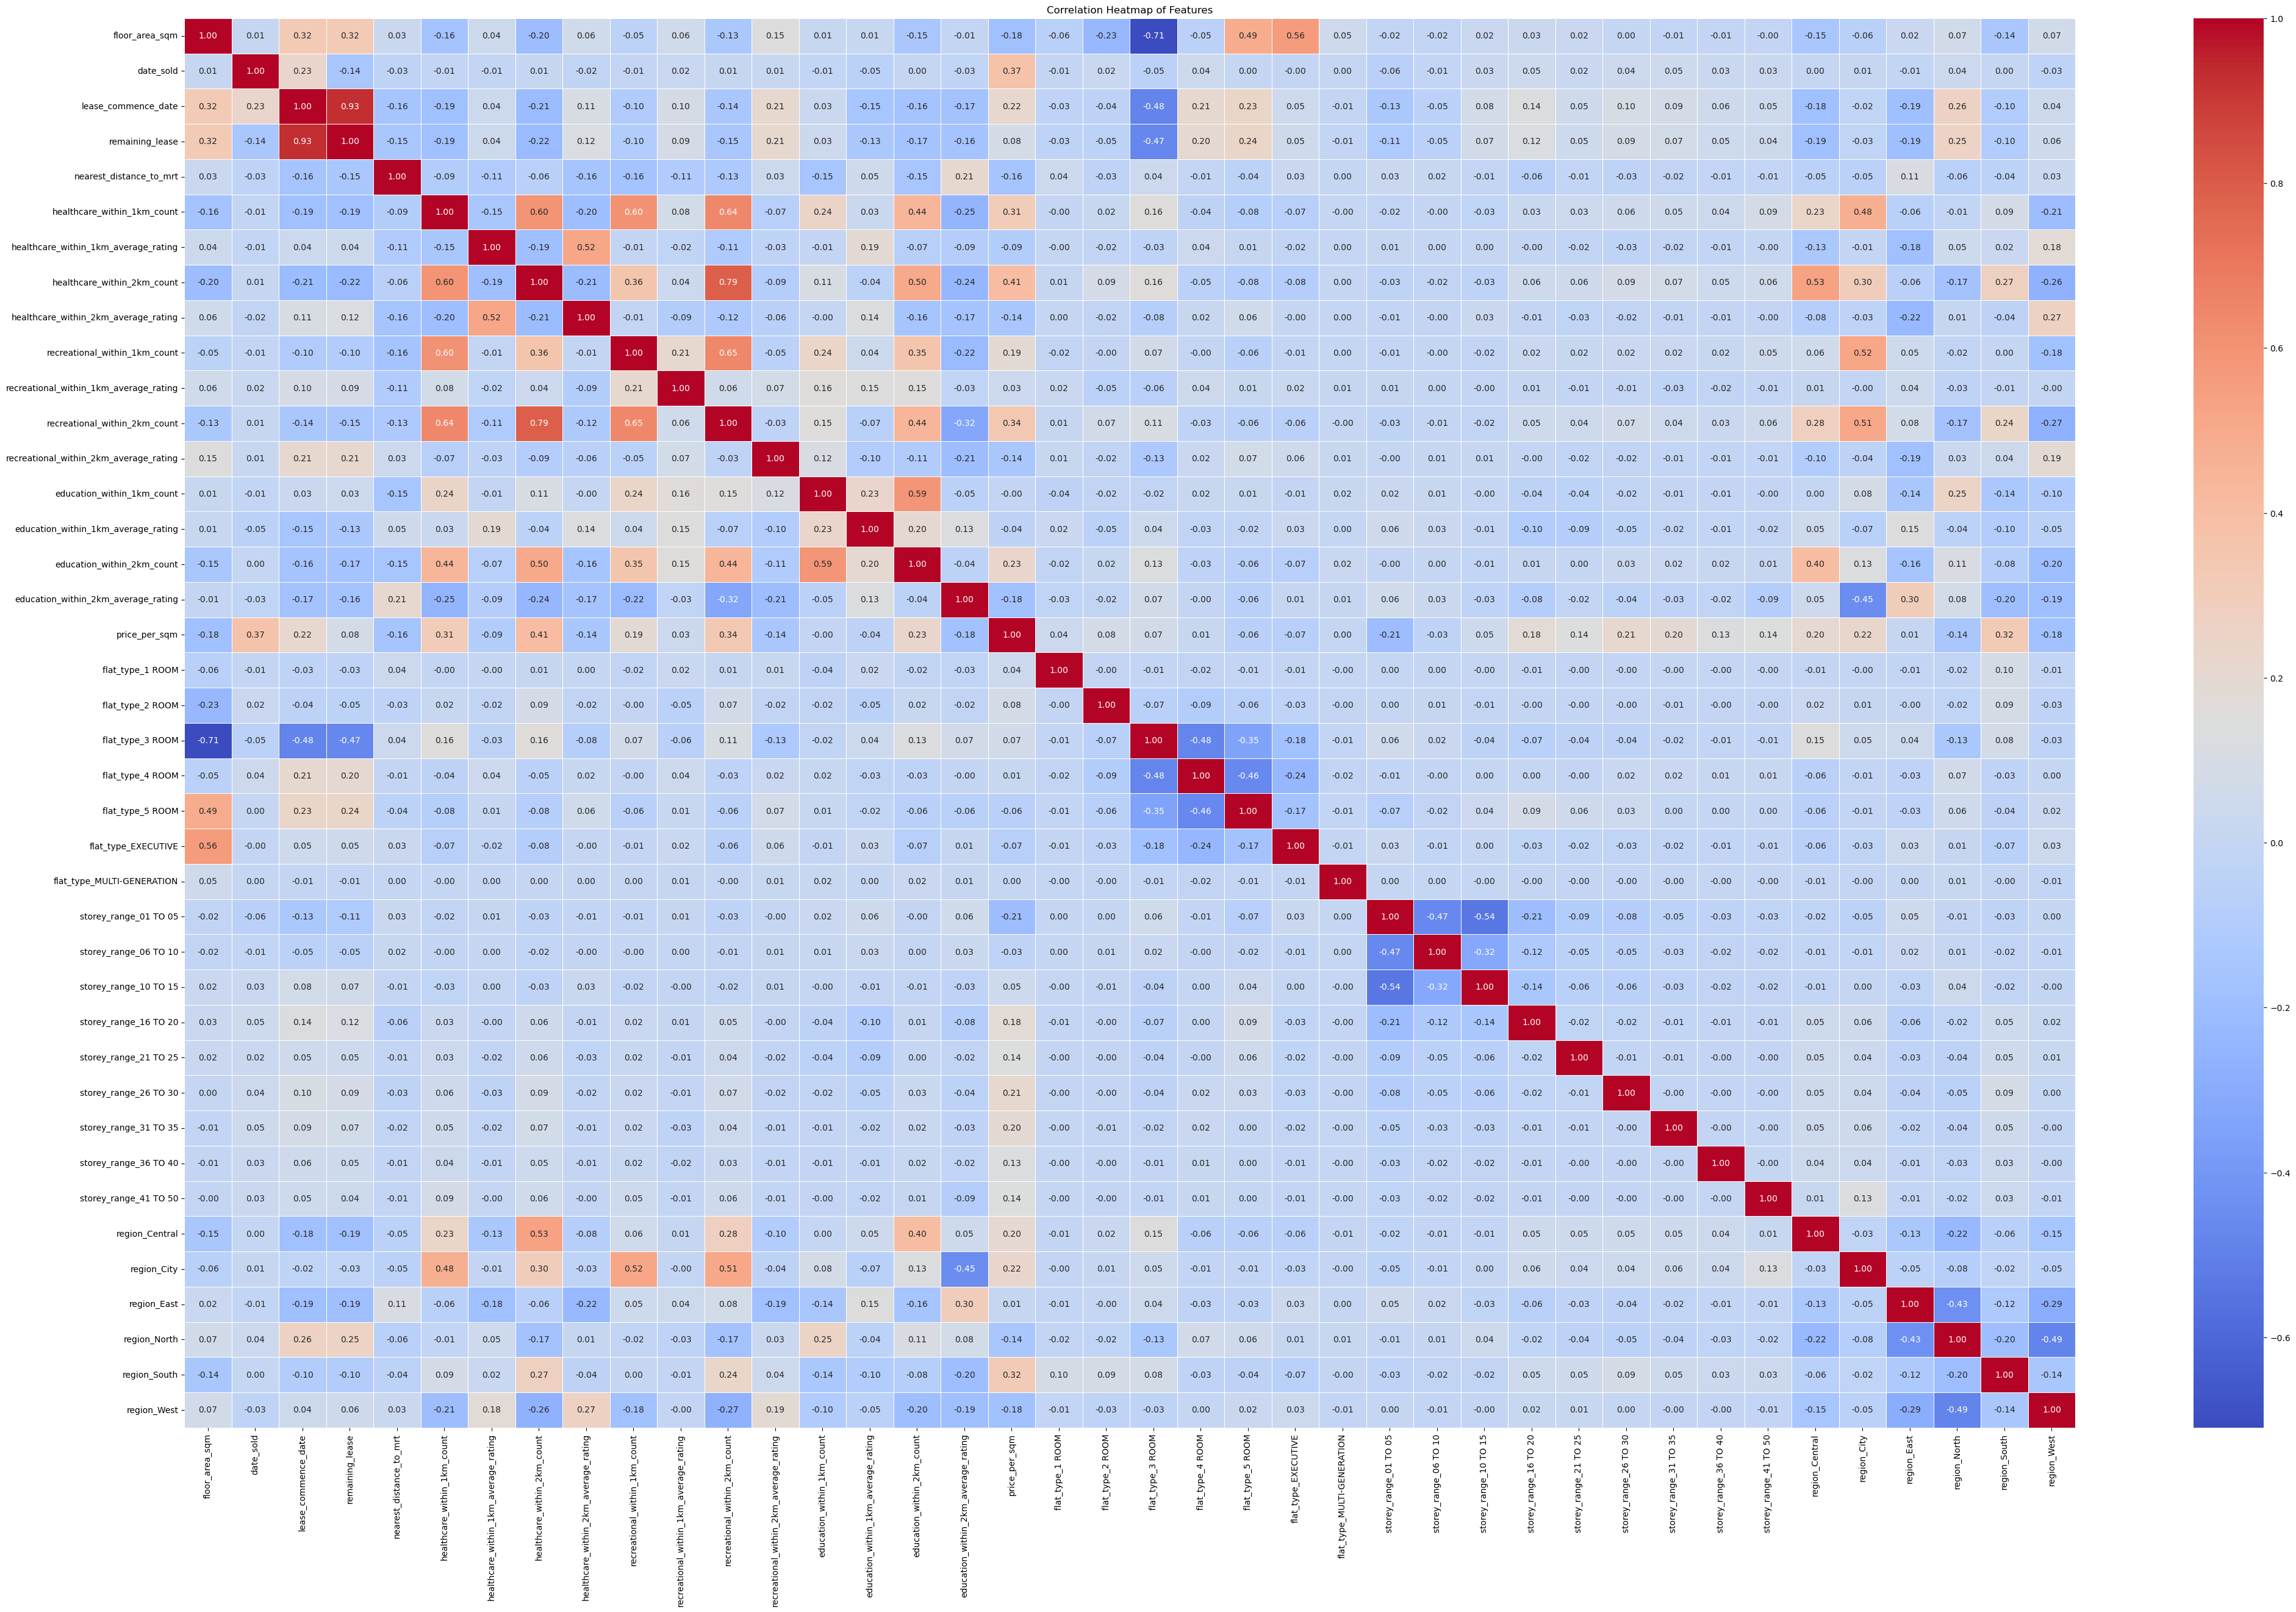

In [15]:
# Compute the correlation matrix
corr_matrix = X_train_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(50, 30))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

# Add a title
plt.title('Correlation Heatmap of Features')

# Show the plot
plt.show()

In [16]:
# Drop Highly Correlated lease_commence_date (with remaining_lease)
X_train_numeric = X_train_numeric.drop(columns=['lease_commence_date'])
X_test_numeric = X_test_numeric.drop(columns=['lease_commence_date'])

In [17]:
# Initialize VarianceThreshold with the desired threshold
threshold = 0.05
selector = VarianceThreshold(threshold)

# Fit the selector to your data
selector.fit(X_train_numeric)

# Get the indices of all features
all_indices = range(len(X_train_numeric.columns))

# Get the indices of the features that are retained
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X_train_numeric.columns[selected_indices]

# Display the selected features
print("Selected features:", selected_features)

# Get the indices of the features that are not selected
not_selected_indices = list(set(all_indices) - set(selected_indices))

# Get the names of the features that are not selected
not_selected_features = X_train_numeric.columns[not_selected_indices]

# Display the features that are not selected
print("Not selected features:", not_selected_features)

Selected features: Index(['floor_area_sqm', 'remaining_lease', 'nearest_distance_to_mrt',
       'healthcare_within_1km_count', 'healthcare_within_1km_average_rating',
       'healthcare_within_2km_count', 'healthcare_within_2km_average_rating',
       'recreational_within_1km_count',
       'recreational_within_1km_average_rating',
       'recreational_within_2km_count', 'education_within_1km_count',
       'education_within_1km_average_rating', 'education_within_2km_count',
       'price_per_sqm', 'flat_type_3 ROOM', 'flat_type_4 ROOM',
       'flat_type_5 ROOM', 'flat_type_EXECUTIVE', 'storey_range_01 TO 05',
       'storey_range_06 TO 10', 'storey_range_10 TO 15', 'region_Central',
       'region_East', 'region_North', 'region_South', 'region_West'],
      dtype='object')
Not selected features: Index(['region_City', 'recreational_within_2km_average_rating',
       'education_within_2km_average_rating', 'flat_type_1 ROOM',
       'flat_type_2 ROOM', 'flat_type_MULTI-GENERATION',
   

In [18]:
# Keep selected features

# Transform your data to keep only the selected features
X_train_selected_array = selector.fit_transform(X_train_numeric)
X_test_selected_array = selector.transform(X_test_numeric)

# Convert the transformed data back to a DataFrame
X_train_selected = pd.DataFrame(X_train_selected_array, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected_array, columns=selected_features)

print(X_train_selected.info())
print(X_test_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253486 entries, 0 to 253485
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   floor_area_sqm                          253486 non-null  object
 1   remaining_lease                         253486 non-null  object
 2   nearest_distance_to_mrt                 253486 non-null  object
 3   healthcare_within_1km_count             253486 non-null  object
 4   healthcare_within_1km_average_rating    253486 non-null  object
 5   healthcare_within_2km_count             253486 non-null  object
 6   healthcare_within_2km_average_rating    253486 non-null  object
 7   recreational_within_1km_count           253486 non-null  object
 8   recreational_within_1km_average_rating  253486 non-null  object
 9   recreational_within_2km_count           253486 non-null  object
 10  education_within_1km_count              253486 non-null 

## Machine Learning Modelling

### Regression Metrics

1. **Mean Absolute Error (MAE)**
   - Formula: $ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $
   - Description: The average of the absolute differences between the predicted values and actual values. It gives an idea of how wrong the predictions were.
   

2. **Mean Absolute Percentage Error (MAPE)**
   - Formula: $ \text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} |\frac{y_i - \hat{y}_i}{y_i}| $
   - Description: Provides an intuitive understanding of model's predictive accuracy relative to actual values. It measures the absolute percentage difference between the predicted values and the actual values.


3. **Mean Squared Error (MSE)**
   - Formula: $ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $
   - Description: The average of the squared differences between the predicted values and actual values. It penalizes larger errors more than MAE.


4. **Root Mean Squared Error (RMSE)**
   - Formula: $ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $
   - Description: The square root of the average of the squared differences between the predicted values and actual values. It is in the same units as the response variable and is sensitive to outliers.


5. **R-squared (Coefficient of Determination)**
   - Formula: $ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $
   - Description: The proportion of the variance in the dependent variable that is predictable from the independent variables. It provides a measure of how well observed outcomes are replicated by the model.



In [19]:
# Evaluation 
def evaluate(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    # mape = np.mean(np.abs((np.array(y_test) - np.array(y_pred)) / np.array(y_test))) * 100
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, y_pred)
    
    print("Mean Absolute Error (MAE):", mae)
    # print("Mean Absolute Percentage Error (MAPE):", mape)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared Coefficient (R^2):", r_squared)

### Baseline Modelling 

We will trial a selected few baseline models to evaluate their performance before selecting the best baseline model to proceed with Hyperparameter Tuning and the subsequent Advanced Modelling which builds on top of Baseline Modelling.

##### Model Training

In [20]:
# Linear Regression
reg_lr = LinearRegression().fit(X_train_selected, y_train)
y_pred_lr = reg_lr.predict(X_test_selected)

evaluate(y_test, y_pred_lr)

Mean Absolute Error (MAE): 15997.765456797359
Mean Squared Error (MSE): 616453880.6893501
Root Mean Squared Error (RMSE): 24828.489295350817
R-squared Coefficient (R^2): 0.9715517505395237


In [21]:
# Decision Tree Regressor
reg_dtr = DecisionTreeRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_dtr = reg_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_dtr)

Mean Absolute Error (MAE): 370.30759142444606
Mean Squared Error (MSE): 6271935.899664233
Root Mean Squared Error (RMSE): 2504.383337203838
R-squared Coefficient (R^2): 0.9997105613207038


Given Decision Tree Regressor outperforms Linear Regression as it has a greater R-Squared Coefficient of 0.99971 > 0.97155, we will be proceeding with Decision Tree Regressor as our baseline model.

##### Cross Validation

<AxesSubplot:title={'center':'Decision Tree Learning Curve (MAPE)'}, xlabel='Training examples', ylabel='Score'>

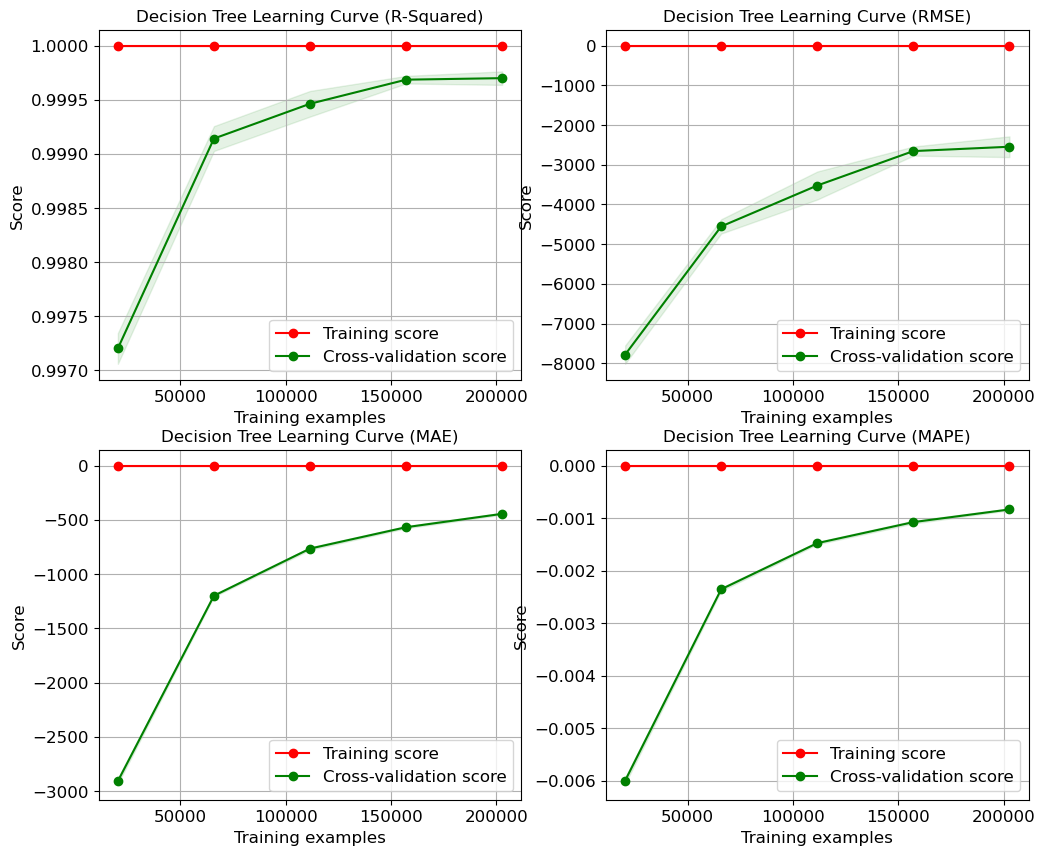

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 

# Learning curves
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (MAPE)", ax=ax4)

Training Score Curve shows the model's performance based on the training dataset as a function of the number of training examples used. Validation Score Curve shows the model's performance on a separate validation dataset as a function of the number of training examples used. 

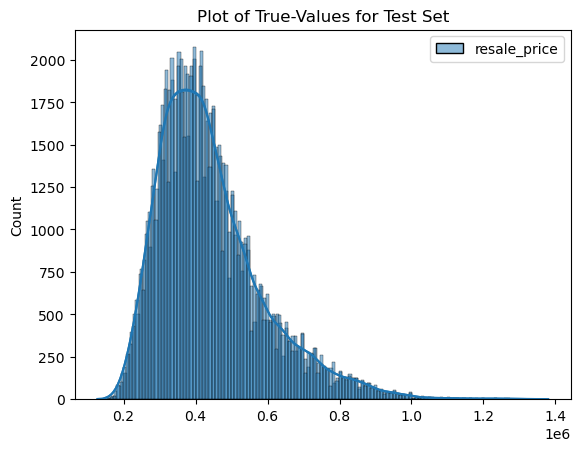

In [23]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_dtr, label='predicted', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

In [25]:
# Print Text Representation of Decision Tree Regressor rules
text_representation_dtr = tree.export_text(reg_dtr)
print(text_representation_dtr)

|--- feature_0 <= 84.50
|   |--- feature_13 <= 5889.65
|   |   |--- feature_13 <= 4340.92
|   |   |   |--- feature_0 <= 74.50
|   |   |   |   |--- feature_13 <= 3752.77
|   |   |   |   |   |--- feature_13 <= 3418.55
|   |   |   |   |   |   |--- feature_0 <= 65.50
|   |   |   |   |   |   |   |--- feature_13 <= 3137.03
|   |   |   |   |   |   |   |   |--- feature_0 <= 62.50
|   |   |   |   |   |   |   |   |   |--- feature_14 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_9 <= 10.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_9 >  10.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [140000.00]
|   |   |   |   |   |   |   |   |   |--- feature_14 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_13 <= 2525.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_13 >  2525.00
|   |   |   |   |   |

In [ ]:
# # Features used
# feature_names = X_train_selected.columns

# # Visualising Decision Tree
# fig_dtr = plt.figure(figsize = (25, 20))
# _ = tree.plot_tree(reg_dtr, 
#                    feature_names = feature_names,  
#                    filled = True)

##### Hyperparameter Tuning

In [26]:
# Decision Tree Model Parameters
reg_dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [28]:
# https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
    
# Use RandomSearch to narrow the scope of parameters for GridSearch
param_dist = {
    "max_depth": randint(1, 20),  
    "min_samples_split": randint(2, 40),  
    "min_samples_leaf": randint(1, 20), 
    "max_features": ["auto", "sqrt", "log2", None],
}

rscv_dtr = RandomizedSearchCV(estimator = DecisionTreeRegressor(random_state=42), param_distributions = param_dist, n_iter = 100, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1).fit(X_train_selected, y_train)

best_params_dtr = rscv_dtr.best_params_
print("Best Parameters For Decision Tree:", best_params_dtr)

y_pred_rscv_dtr = rscv_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_rscv_dtr)

Best Parameters For Decision Tree: {'max_depth': 16, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 8}
Mean Absolute Error (MAE): 636.088724218489
Mean Squared Error (MSE): 8677087.333265807
Root Mean Squared Error (RMSE): 2945.6896193023813
R-squared Coefficient (R^2): 0.9995995678626095


In [29]:
# Use GridSearch from RandomizedSearch best parameters
params = { 
    'max_depth': [12, 13, 14, 15, 16, 17, 18],     
    'min_samples_split': [5, 6, 7, 8, 9, 10], 
    'min_samples_leaf': [2, 3, 4, 5, 6],
    "max_features": ["auto"],
}

gscv_dtr = GridSearchCV(estimator = DecisionTreeRegressor(random_state=42), param_grid = params, scoring = 'neg_root_mean_squared_error', n_jobs = -1).fit(X_train_selected, y_train)

best_params_dtr = gscv_dtr.best_params_
print("Best Parameters For Decision Tree:", best_params_dtr)

y_pred_gscv_dtr = gscv_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_dtr)

Best Parameters For Decision Tree: {'max_depth': 18, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 6}
Mean Absolute Error (MAE): 417.9523217730319
Mean Squared Error (MSE): 7446045.23300012
Root Mean Squared Error (RMSE): 2728.744259361826
R-squared Coefficient (R^2): 0.9996563782645905


##### Feature Evaluation

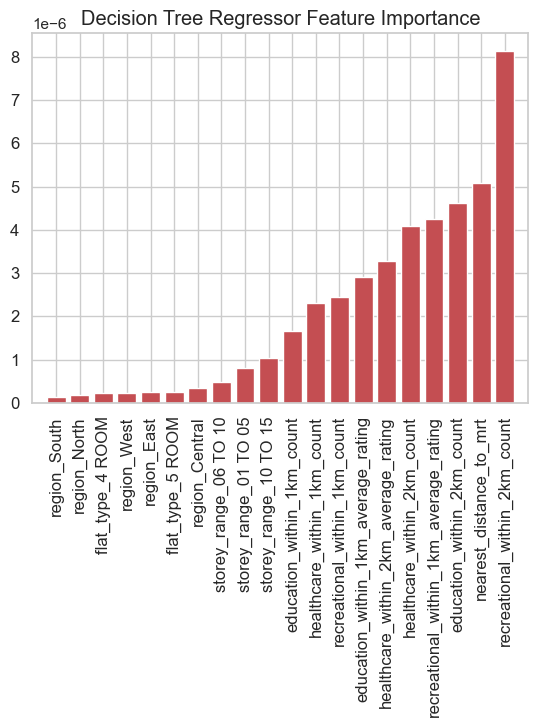

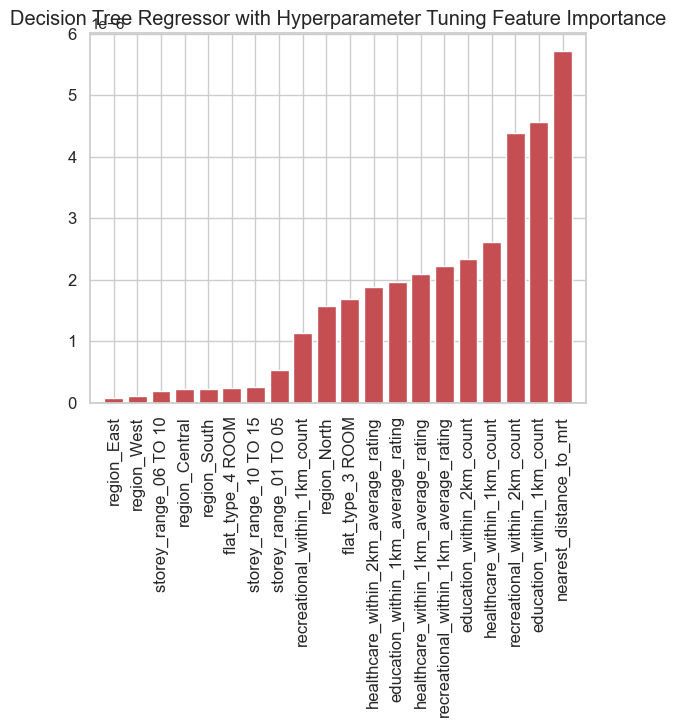

In [30]:
# Features Used
feature_names = X_train_selected.columns

# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_dtr, feature_names = feature_names,
                                         title="Decision Tree Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending");
skplt.estimators.plot_feature_importances(gscv_dtr.best_estimator_, feature_names = feature_names,
                                         title="Decision Tree Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending");

The Decision Tree Regressor Feature Importance plot displays the significance of each attribute in the regression model. The features, labeled on the x-axis, are ranked according to their importance scores on the y-axis. A higher bar denotes a greater influence on the model's predictions, with "recreational_within_2km_average_rating" standing out as the most impactful feature in this particular model. However, after hyperparameter tuning, "nearest_distance_to_mrt" stood out as the most impactful feature in this particular model.

### Advanced Modelling 

From the Baseline Decision Tree Model, we will look into more complex Ensemble models for better performance.

#### Random Forest Regressor

In [31]:
# Random Forest Regressor
reg_rfr = RandomForestRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_rfr = reg_rfr.predict(X_test_selected)

evaluate(y_test, y_pred_rfr)

Mean Absolute Error (MAE): 251.47289441513638
Mean Squared Error (MSE): 4011083.9197759186
Root Mean Squared Error (RMSE): 2002.7690630164823
R-squared Coefficient (R^2): 0.9998148956158259


In [ ]:
## USE CELLS HERE

#### XGBoost Regressor

In [ ]:
reg_xgbr = XGBRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_xgbr = reg_xgbr.predict(X_test_selected)

evaluate(y_test, y_pred_xgbr)

In [ ]:
## USE CELLS HERE

#### LightGBM Regressor

In [ ]:
reg_lgbmr = LGBMRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_lgmbr = reg_lgbmr.predict(X_test_selected)

evaluate(y_test, y_pred_lgbmr)

In [ ]:
## USE CELLS HERE

#### CatBoost Regressor

In [33]:
reg_cbr = cb.CatBoostRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_cbr = reg_cbr.predict(X_test_selected)

evaluate(y_test, y_pred_cbr)

Learning rate set to 0.098176
0:	learn: 133983.2227914	total: 183ms	remaining: 3m 2s
1:	learn: 122654.4395760	total: 208ms	remaining: 1m 43s
2:	learn: 112508.1002723	total: 229ms	remaining: 1m 16s
3:	learn: 103346.2128993	total: 249ms	remaining: 1m 2s
4:	learn: 95017.0975006	total: 268ms	remaining: 53.4s
5:	learn: 87522.9638465	total: 287ms	remaining: 47.5s
6:	learn: 80797.4608775	total: 305ms	remaining: 43.2s
7:	learn: 74685.5959329	total: 322ms	remaining: 39.9s
8:	learn: 68932.5361395	total: 342ms	remaining: 37.7s
9:	learn: 63921.7280263	total: 361ms	remaining: 35.7s
10:	learn: 59182.0566974	total: 378ms	remaining: 34s
11:	learn: 54852.7804771	total: 395ms	remaining: 32.5s
12:	learn: 51014.8502410	total: 412ms	remaining: 31.3s
13:	learn: 47415.3719573	total: 430ms	remaining: 30.3s
14:	learn: 44158.1201672	total: 449ms	remaining: 29.5s
15:	learn: 41170.5849796	total: 466ms	remaining: 28.7s
16:	learn: 38471.5843847	total: 483ms	remaining: 27.9s
17:	learn: 36070.4875304	total: 501ms	rem

151:	learn: 5238.7157311	total: 2.77s	remaining: 15.5s
152:	learn: 5221.8183976	total: 2.79s	remaining: 15.5s
153:	learn: 5206.5044681	total: 2.81s	remaining: 15.4s
154:	learn: 5195.7319788	total: 2.83s	remaining: 15.4s
155:	learn: 5179.8653314	total: 2.85s	remaining: 15.4s
156:	learn: 5170.4238817	total: 2.86s	remaining: 15.4s
157:	learn: 5157.4536138	total: 2.88s	remaining: 15.4s
158:	learn: 5149.9309871	total: 2.9s	remaining: 15.3s
159:	learn: 5136.7454140	total: 2.92s	remaining: 15.3s
160:	learn: 5128.0464822	total: 2.94s	remaining: 15.3s
161:	learn: 5118.6866603	total: 2.95s	remaining: 15.3s
162:	learn: 5112.9978822	total: 2.97s	remaining: 15.2s
163:	learn: 5108.0351889	total: 2.98s	remaining: 15.2s
164:	learn: 5094.4830030	total: 3.01s	remaining: 15.2s
165:	learn: 5088.3970240	total: 3.03s	remaining: 15.2s
166:	learn: 5078.7864230	total: 3.04s	remaining: 15.2s
167:	learn: 5068.9470920	total: 3.06s	remaining: 15.2s
168:	learn: 5059.8939049	total: 3.08s	remaining: 15.1s
169:	learn:

303:	learn: 4100.3544455	total: 6.28s	remaining: 14.4s
304:	learn: 4091.0589660	total: 6.34s	remaining: 14.4s
305:	learn: 4088.7686795	total: 6.4s	remaining: 14.5s
306:	learn: 4080.8610424	total: 6.45s	remaining: 14.6s
307:	learn: 4079.7538374	total: 6.5s	remaining: 14.6s
308:	learn: 4071.5486513	total: 6.59s	remaining: 14.7s
309:	learn: 4067.3576612	total: 6.66s	remaining: 14.8s
310:	learn: 4061.6720831	total: 6.72s	remaining: 14.9s
311:	learn: 4059.4346717	total: 6.79s	remaining: 15s
312:	learn: 4055.1278805	total: 6.84s	remaining: 15s
313:	learn: 4050.3867566	total: 6.89s	remaining: 15.1s
314:	learn: 4042.9356478	total: 6.95s	remaining: 15.1s
315:	learn: 4040.8265776	total: 6.98s	remaining: 15.1s
316:	learn: 4036.5216491	total: 7s	remaining: 15.1s
317:	learn: 4033.6717061	total: 7.04s	remaining: 15.1s
318:	learn: 4031.2339484	total: 7.09s	remaining: 15.1s
319:	learn: 4029.7272353	total: 7.14s	remaining: 15.2s
320:	learn: 4024.7178089	total: 7.21s	remaining: 15.3s
321:	learn: 4020.93

457:	learn: 3645.9828599	total: 13.2s	remaining: 15.7s
458:	learn: 3643.0487089	total: 13.3s	remaining: 15.7s
459:	learn: 3638.2967873	total: 13.3s	remaining: 15.6s
460:	learn: 3635.0461439	total: 13.4s	remaining: 15.6s
461:	learn: 3632.3233556	total: 13.4s	remaining: 15.6s
462:	learn: 3630.2177140	total: 13.4s	remaining: 15.6s
463:	learn: 3628.0458283	total: 13.5s	remaining: 15.6s
464:	learn: 3625.9834813	total: 13.5s	remaining: 15.6s
465:	learn: 3624.9495212	total: 13.6s	remaining: 15.6s
466:	learn: 3623.1449095	total: 13.6s	remaining: 15.5s
467:	learn: 3621.9903166	total: 13.7s	remaining: 15.5s
468:	learn: 3620.0451181	total: 13.7s	remaining: 15.5s
469:	learn: 3617.0727095	total: 13.7s	remaining: 15.5s
470:	learn: 3616.5074745	total: 13.8s	remaining: 15.5s
471:	learn: 3615.1343303	total: 13.8s	remaining: 15.5s
472:	learn: 3612.6255408	total: 13.9s	remaining: 15.4s
473:	learn: 3610.7475338	total: 13.9s	remaining: 15.4s
474:	learn: 3608.9541581	total: 13.9s	remaining: 15.4s
475:	learn

612:	learn: 3377.1695876	total: 19.8s	remaining: 12.5s
613:	learn: 3375.8494832	total: 19.9s	remaining: 12.5s
614:	learn: 3375.1169031	total: 19.9s	remaining: 12.5s
615:	learn: 3374.4334257	total: 19.9s	remaining: 12.4s
616:	learn: 3373.7397186	total: 20s	remaining: 12.4s
617:	learn: 3371.0920831	total: 20s	remaining: 12.4s
618:	learn: 3369.0780560	total: 20.1s	remaining: 12.3s
619:	learn: 3367.2533009	total: 20.1s	remaining: 12.3s
620:	learn: 3366.4336143	total: 20.1s	remaining: 12.3s
621:	learn: 3364.4838376	total: 20.2s	remaining: 12.3s
622:	learn: 3362.7408742	total: 20.2s	remaining: 12.2s
623:	learn: 3359.6194146	total: 20.3s	remaining: 12.2s
624:	learn: 3357.2013965	total: 20.3s	remaining: 12.2s
625:	learn: 3355.5828303	total: 20.4s	remaining: 12.2s
626:	learn: 3354.4683011	total: 20.4s	remaining: 12.1s
627:	learn: 3353.0320675	total: 20.4s	remaining: 12.1s
628:	learn: 3351.7444108	total: 20.5s	remaining: 12.1s
629:	learn: 3349.7446748	total: 20.5s	remaining: 12s
630:	learn: 3348

763:	learn: 3192.7537887	total: 25.6s	remaining: 7.9s
764:	learn: 3191.4902264	total: 25.6s	remaining: 7.87s
765:	learn: 3190.8359780	total: 25.6s	remaining: 7.83s
766:	learn: 3190.4002250	total: 25.7s	remaining: 7.8s
767:	learn: 3189.0579660	total: 25.7s	remaining: 7.77s
768:	learn: 3188.4957334	total: 25.7s	remaining: 7.73s
769:	learn: 3187.9198229	total: 25.8s	remaining: 7.7s
770:	learn: 3187.1823369	total: 25.8s	remaining: 7.67s
771:	learn: 3186.7333247	total: 25.8s	remaining: 7.63s
772:	learn: 3185.7909432	total: 25.9s	remaining: 7.6s
773:	learn: 3185.0699387	total: 25.9s	remaining: 7.57s
774:	learn: 3183.8425587	total: 25.9s	remaining: 7.53s
775:	learn: 3182.4661809	total: 26s	remaining: 7.5s
776:	learn: 3181.9178993	total: 26s	remaining: 7.47s
777:	learn: 3181.3481963	total: 26.1s	remaining: 7.44s
778:	learn: 3180.3923182	total: 26.1s	remaining: 7.41s
779:	learn: 3179.8447686	total: 26.2s	remaining: 7.38s
780:	learn: 3178.5617462	total: 26.2s	remaining: 7.34s
781:	learn: 3177.57

913:	learn: 3071.6236216	total: 31.5s	remaining: 2.96s
914:	learn: 3070.1439918	total: 31.5s	remaining: 2.93s
915:	learn: 3069.6726564	total: 31.6s	remaining: 2.9s
916:	learn: 3069.1678892	total: 31.7s	remaining: 2.87s
917:	learn: 3067.3615032	total: 31.7s	remaining: 2.83s
918:	learn: 3067.0679796	total: 31.7s	remaining: 2.8s
919:	learn: 3066.2919323	total: 31.8s	remaining: 2.76s
920:	learn: 3065.8398975	total: 31.8s	remaining: 2.73s
921:	learn: 3065.2297054	total: 31.9s	remaining: 2.7s
922:	learn: 3064.3102049	total: 31.9s	remaining: 2.66s
923:	learn: 3063.2907525	total: 32s	remaining: 2.63s
924:	learn: 3062.8201339	total: 32s	remaining: 2.6s
925:	learn: 3062.2404981	total: 32.1s	remaining: 2.56s
926:	learn: 3061.7890240	total: 32.1s	remaining: 2.53s
927:	learn: 3060.7464566	total: 32.2s	remaining: 2.5s
928:	learn: 3059.7625833	total: 32.2s	remaining: 2.46s
929:	learn: 3059.2399526	total: 32.2s	remaining: 2.43s
930:	learn: 3058.7041830	total: 32.3s	remaining: 2.39s
931:	learn: 3058.16

In [ ]:
## USE CELLS HERE